# Granovetter threshold model

Granovetter threshold model > Kempe generalize this model for the spread of ideas in social networks — linear
threshold (LT) and independent cascade (IC) > This agent-based model (ABM) is a probabilistic graph-based model inspired by the Independent Cascade (IC) model.

A "radical" will have a low threshold: the benefits of rioting are high to him, the cost of arrest, low. Some would be sufficiently radical to have a threshold of 0%/0-people who will riot even when no one else does. These are the "instigators." Conservatives will have high thresholds: the benefits of rioting are small or negative to them and the consequences of arrest high since they are likely to be "respectable citizens" rather than "known rabble-rousers." Thresholds of 80% or 90%0 may be common, and we may allow for those individuals who would not join under any circumstances by assigning them a threshold of 100%.

the aim of the formal model presented here is the same: to predict, from the initial distribution of thresholds, the ultimate number or proportion making each of the two decisions. Mathematically, the question is one of finding an equilibrium in a process occurring over time.

In [1]:
# Setting up the model - agen variables and model-level parameters

from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector

class GranovetterAgent(Agent):
    """An agent with fixed initial wealth."""

    # 1 Initialization
    # the variation of norms and preferences within the interacting group
    def __init__(self, unique_id, engagement_treshold, model):
        super().__init__(unique_id, model)
        
        self.engagement_treshold = engagement_treshold
        self.engaged = False
        self.decision = False
        #print("Hi, I am agent " + str(self.unique_id) + "." + str(self.engagement_treshold))

    # 2 Step function
    # join a riot, for example-we can infer from this that most ended up sharing the same norm or belief 
    # about the situation, whether or not they did so at the beginning.
    # the decision can be thought of as having a positive and negative side-deciding to do a thing or not to, as in deciding whether to join a riot-though this is not required for the formal analysis.
    def step(self):    # < agent step: 'rules' action when activated
        # 3 the aggregation of individual preference of similar neighbours
        if self.engaged == True:
            return
        other_agents = self.model.schedule.agents
        engagement_rate = sum(agent.engaged == True for agent in other_agents) / len(other_agents)
        
        # 4 binary decisions-those where an actor has two distinct and mutually exclusive behavioral alternative
        # A further requirement is that the decision be one where the costs and benefits to the actor of making one or the other choice depend in part on how many others make which choice. We may take riots as an example. The cost to an individual of joining a riot declines as riot size increases, since the probability of being apprehended is smaller the larger the number involved
        # A person's threshold for joining a riot is defined here as the proportion of the group he would have to see join before he would do so.
        if engagement_rate >= self.engagement_treshold:
            self.decision = True
            
    def advance(self):
        if self.engaged == True:
            return
        elif self.decision == True:
            self.engaged = True

# Data collection
def get_engagement_ratio(model):
    '''
    Find the % of agents that are rioting.
    '''
    
    agent_engeged = [agent.engaged for agent in model.schedule.agents]
    N = model.num_agents
    
    engagement_rate = sum(agent_engeged) / N
    
    return engagement_rate

class GranovetterModel(Model):
    """A model with some number of agents."""

    def __init__(self, N, mu=0.25, sigma=0.122):
        super().__init__()
        
        self.num_agents = N    # < model-level parameter: how many agents the model contains
        self.schedule = SimultaneousActivation(self)
        
        # Create agents
        # Using uniform distribution
        # Riot situation - instigator starts
        #for i in range(self.num_agents):
        #    a = GranovetterAgent(i, i * (1 / self.num_agents), self)
        #    self.schedule.add(a)
            
        # Another riot situation - only instigator riots
        #a = GranovetterAgent(0, 0.0, self)
        #self.schedule.add(a)
        #for i in range(1, self.num_agents):
        #    a = GranovetterAgent(i, (i+1) * (1 / self.num_agents), self)
        #    self.schedule.add(a)
        
        # Using normal distribution
        for i in range(self.num_agents):
            a = GranovetterAgent(i, max(self.random.gauss(mu, sigma), 0.0), self) # Initial engagement rate in product basedon normal distr, clip negative to zero
            self.schedule.add(a)
        
        # Using perturbed uniform distribution
        #a = GranovetterAgent(0, 0.0, self)
        #self.schedule.add(a)
        #a = GranovetterAgent(1, 0.2, self)
        #self.schedule.add(a)
        #a = GranovetterAgent(2, 0.2, self)
        #self.schedule.add(a)
        #for i in range(3, self.num_agents):
        #    a = GranovetterAgent(i, i * (1 / self.num_agents), self)
        #    self.schedule.add(a)
        
        self.datacollector = DataCollector(    # < Note that we have both an agent and model data collector
            model_reporters={"engagement_ratio": get_engagement_ratio}, agent_reporters={"engaged": "engaged"}
        )
        
    def step(self):
        self.datacollector.collect(self)
        """Advance the model by one step."""
        self.schedule.step()    # < model step: activate and execute each agent's step

In [2]:
# Test the model

model = GranovetterModel(100)
for i in range(10):
    model.step()

<AxesSubplot:>

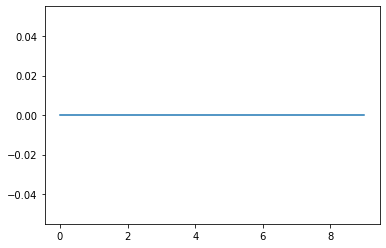

In [3]:
# Show results

model_data = model.datacollector.get_model_vars_dataframe()
model_data.engagement_ratio.plot()

In [4]:
agent_data = model.datacollector.get_agent_vars_dataframe()
agent_data.head()

engaged
Step AgentID         
0    0          False
     1          False
     2          False
     3          False
     4          False

In [5]:
# Test the batch model

from mesa.batchrunner import batch_run

params = {"N": 100, "mu": 0.25, "sigma": 0.122}

results = batch_run(
    GranovetterModel,
    parameters=params,
    iterations=15,
    max_steps=10,
    number_processes=None,
    data_collection_period=1,
    display_progress=True,
)

15it [00:00, 115.92it/s]


In [6]:
# Collect batch data as Pandas dataframe

import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'N', 'mu', 'sigma', 'engagement_ratio',
       'AgentID', 'engaged'],
      dtype='object')


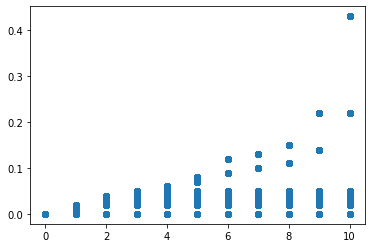

In [7]:
# Trend of coefficients after each iteration

# For a jupyter notebook add the following line:
%matplotlib inline

# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

plt.scatter(results_df.Step.values, results_df.engagement_ratio.values)